# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.


# Step 1: Load and Check Out the Data

First things first, let's load the data and take a quick look at what we're working with.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Inspect the data
print(portfolio.head())
print(profile.head())
print(transcript.head())

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96f

# Step 2: Clean and Prep the Data

## Portfolio Data

This dataset has info about the offers, like their type, difficulty, and how long they last. Let's tidy it up a bit.

In [2]:
# One-hot encode the channels column
portfolio['channels'] = portfolio['channels'].apply(lambda x: ','.join(x))
portfolio = pd.get_dummies(portfolio, columns=['channels'], prefix='', prefix_sep='')

# One-hot encode the offer_type column
#portfolio = pd.get_dummies(portfolio, columns=['offer_type'], prefix='', prefix_sep='')

print(portfolio.head())

   difficulty  duration                                id     offer_type  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd           bogo   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo   
2           0         4  3f207df678b143eea3cee63160fa8bed  informational   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount   

   reward  email,mobile,social  web,email  web,email,mobile  \
0      10                    1          0                 0   
1      10                    0          0                 0   
2       0                    0          0                 1   
3       5                    0          0                 1   
4       5                    0          1                 0   

   web,email,mobile,social  
0                        0  
1                        1  
2                        0  
3                        0  
4                  

## Profile Data

This one has customer details like age, gender, and income. Let's clean it up and handle missing values.

In [3]:
# Convert became_member_on to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Handle weird ages (like 118) and missing gender/income
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile['gender'] = profile['gender'].fillna('U')  # U for unknown
profile['income'] = profile['income'].fillna(profile['income'].median())

print(profile.head())

    age became_member_on gender                                id    income
0   NaN       2017-02-12      U  68be06ca386d4c31939f3a4f0e3dd783   64000.0
1  55.0       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2   NaN       2018-07-12      U  38fe809add3b4fcf9315a9694bb96ff5   64000.0
3  75.0       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4   NaN       2017-08-04      U  a03223e636434f42ac4c3df47e8bac43   64000.0


## Transcript Data

This dataset logs all the events, like when offers are received, viewed, or completed. Let's clean it up.

In [4]:
# Extract offer id and transaction amount from the value column
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

# Drop the original value column
transcript.drop(columns=['value'], inplace=True)

print(transcript.head())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  


# Step 3: Explore the Data

Let’s dig into the data and see what we can find!

Check Out Customer Demographics
Who are Starbucks' customers? Let’s look at age, income, and gender.

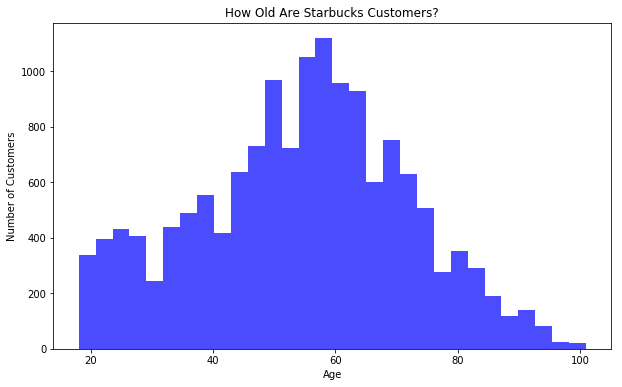

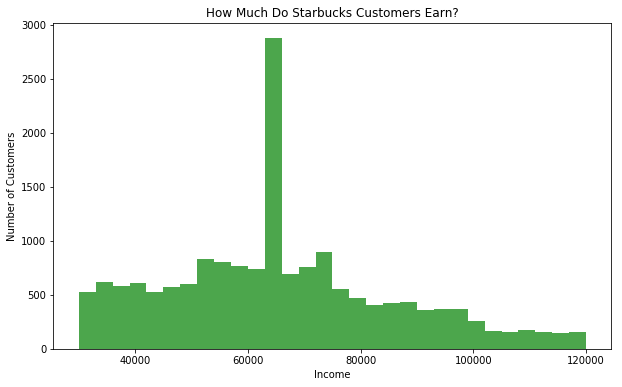

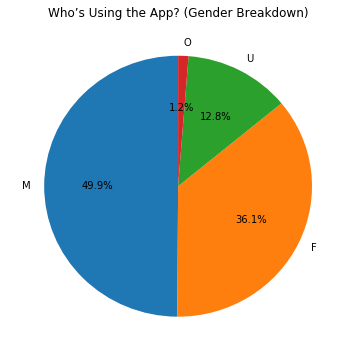

In [5]:
import matplotlib.pyplot as plt #required library for the plot
# Plot age distribution
plt.figure(figsize=(10, 6))
plt.hist(profile['age'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('How Old Are Starbucks Customers?')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

# Plot income distribution
plt.figure(figsize=(10, 6))
plt.hist(profile['income'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('How Much Do Starbucks Customers Earn?')
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.show()

# Plot gender distribution
gender_counts = profile['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Who’s Using the App? (Gender Breakdown)')
plt.show()

Explore Customer Behavior
What do customers do on the app? Let’s look at transactions and offers.

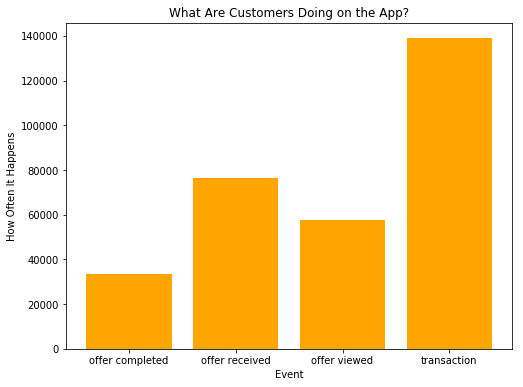

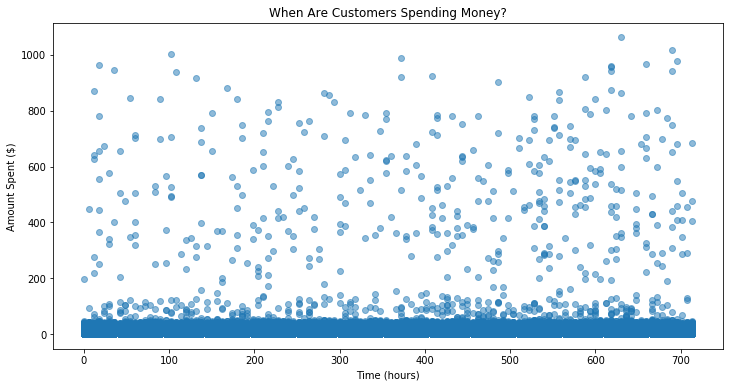

In [6]:
# Plot event distribution
event_counts = transcript['event'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(event_counts.index, event_counts.values, color='orange')
plt.title('What Are Customers Doing on the App?')
plt.xlabel('Event')
plt.ylabel('How Often It Happens')
plt.show()

# Plot transaction amounts over time
transactions = transcript[transcript['event'] == 'transaction']
plt.figure(figsize=(12, 6))
plt.scatter(transactions['time'], transactions['amount'], alpha=0.5)
plt.title('When Are Customers Spending Money?')
plt.xlabel('Time (hours)')
plt.ylabel('Amount Spent ($)')
plt.show()

## Step 4: Combine Data and Analyze Offers

Now, let’s combine everything to see which offers work best for different groups of customers.

In [7]:
# Merge transcript with profile data
merged_data = pd.merge(transcript, profile, left_on='person', right_on='id', how='left')

# Merge with portfolio data
merged_data = pd.merge(merged_data, portfolio, left_on='offer_id', right_on='id', how='left')

print(merged_data.head())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer_id  amount   age became_member_on gender  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  75.0       2017-05-09      F   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN   NaN       2017-08-04      U   
2  2906b810c7d4411798c6938adc9daaa5     NaN  68.0       2018-04-26      M   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN   NaN       2017-09-25      U   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN   NaN       2017-10-02      U   

                               id_x    income  difficulty  duration  \
0  78afa995795e4d85b5d9ceeca43f5fef  100000.0         5.0       7.0   
1  a03223e636434f42ac4c3df47

### Who’s Completing Offers?

Let’s see which groups are most likely to complete offers.

#### Verify Columns in merged_data

In [8]:
print(merged_data.columns)

Index(['event', 'person', 'time', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'id_x', 'income', 'difficulty',
       'duration', 'id_y', 'offer_type', 'reward', 'email,mobile,social',
       'web,email', 'web,email,mobile', 'web,email,mobile,social'],
      dtype='object')


In [9]:
# Define age bins and labels
bins = [17, 30, 50, np.inf]
labels = ['Young', 'Middle-aged', 'Older']

# Create age_group column
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels)

# Check the new column
print(merged_data[['age', 'age_group']].head())

    age age_group
0  75.0     Older
1   NaN       NaN
2  68.0     Older
3   NaN       NaN
4   NaN       NaN


Step 2: Create Demographic Groups
If the columns are missing, you need to create them. Here’s how:

Create age_group

In [10]:
# Define age bins and labels
bins = [17, 30, 50, np.inf]
labels = ['Young', 'Middle-aged', 'Older']

# Create age_group column
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels)

# Check the new column
print(merged_data[['age', 'age_group']].head())

    age age_group
0  75.0     Older
1   NaN       NaN
2  68.0     Older
3   NaN       NaN
4   NaN       NaN


Create income_group

In [11]:
# Define income bins and labels
bins = [0, 50000, 100000, np.inf]
labels = ['Low', 'Medium', 'High']

# Create income_group column
merged_data['income_group'] = pd.cut(merged_data['income'], bins=bins, labels=labels)

# Check the new column
print(merged_data[['income', 'income_group']].head())

     income income_group
0  100000.0       Medium
1   64000.0       Medium
2   70000.0       Medium
3   64000.0       Medium
4   64000.0       Medium


Create gender_group

In [12]:
# Simplify gender column
merged_data['gender_group'] = merged_data['gender'].replace({'O': 'Other', 'U': 'Other'})

# Check the new column
print(merged_data[['gender', 'gender_group']].head())

  gender gender_group
0      F            F
1      U        Other
2      M            M
3      U        Other
4      U        Other


Step 3: Verify the Columns Again
After creating the demographic groups, check the columns in merged_data again to confirm that the new columns (gender_group, age_group, income_group) exist.

In [13]:
print(merged_data.columns)

Index(['event', 'person', 'time', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'id_x', 'income', 'difficulty',
       'duration', 'id_y', 'offer_type', 'reward', 'email,mobile,social',
       'web,email', 'web,email,mobile', 'web,email,mobile,social', 'age_group',
       'income_group', 'gender_group'],
      dtype='object')


In [14]:
# Group by demographics and offer type, then count completions
completion_rates = merged_data[merged_data['event'] == 'offer completed'].groupby(
    ['gender_group', 'age_group', 'income_group', 'offer_type']
).size().unstack(fill_value=0)

# Check the resulting DataFrame
print(completion_rates.head())

offer_type                             bogo  discount
gender_group age_group   income_group                
F            Young       Low            229       245
                         Medium         321       300
             Middle-aged Low            355       392
                         Medium        1244      1349
                         High            64        61


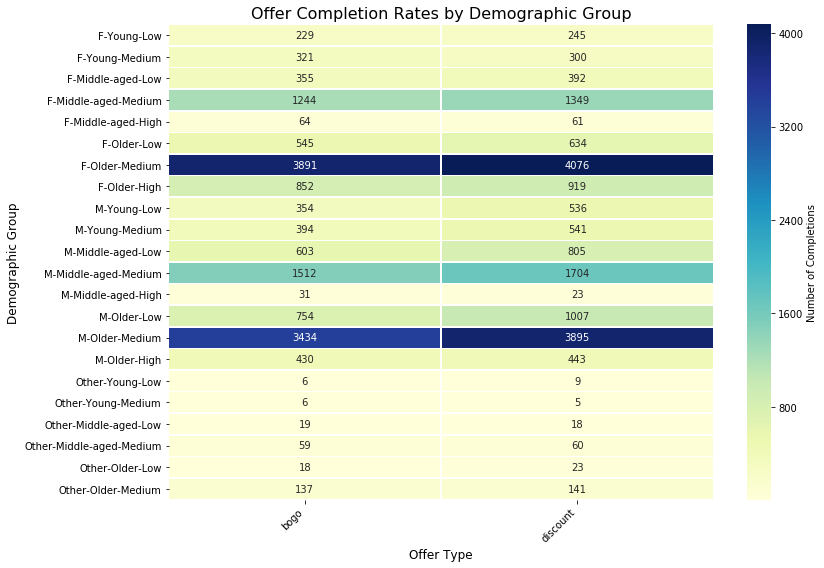

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure completion_rates is a DataFrame
completion_rates = completion_rates.reset_index()

# Melt the data for heatmap
heatmap_data = completion_rates.melt(
    id_vars=['gender_group', 'age_group', 'income_group'], 
    var_name='offer_type', 
    value_name='completions'
)

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot_table(
    index=['gender_group', 'age_group', 'income_group'], 
    columns='offer_type', 
    values='completions', 
    aggfunc='sum'  # Ensure values are summed (if there are duplicates)
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_pivot, 
    annot=True, 
    fmt='d',  # Format annotations as integers
    cmap='YlGnBu',  # Color map
    linewidths=0.5,  # Add lines between cells
    cbar_kws={'label': 'Number of Completions'}  # Add a label to the color bar
)

# Add titles and labels
plt.title('Offer Completion Rates by Demographic Group', fontsize=16)
plt.xlabel('Offer Type', fontsize=12)
plt.ylabel('Demographic Group', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()